In [29]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from object_detection.data_decoders import tf_example_decoder

from xml.dom import minidom
from xml.etree.ElementTree import Element, SubElement, ElementTree

In [30]:
def make_elements(dom, root_node, element_map):
    """ add sub-node for root_node """
    node = dom.createElement(element_map.get('name'))
    root_node.appendChild(node)
    if element_map.get('text') != 'None':
        text = dom.createTextNode(str(element_map.get('text')))
        node.appendChild(text)
    if element_map.get('sub') != 'None':
        for item in element_map.get('sub'):
            make_elements(dom, node, item)

In [35]:
def write_labels(img_name, boxes, label_path):
    print(label_path + img_name + '.txt')
    f = open(label_path + img_name + '.txt', 'w')
    for box in boxes:
        f.write(
            str(14) + ' '
            + str((box[1] + box[3]) / 2) + ' '
            + str((box[0] + box[2]) / 2) + ' '
            + str(box[3] - box[1]) + ' ' 
            + str(box[2] - box[0])+ '\n')
    f.close()

In [40]:
def write_to_voc(image_raw, save_path):
    """ generate annotations from tfrecord only one image infomation """
    image = image_raw['image'][...,::-1] # BGR <=> RGB
    img_name = str(image_raw['source_id'], encoding='utf-8')
    if img_name.split('.')[-1] != 'jpg':
        img_name = img_name + '.jpg'
    img_path = save_path + 'JPEGImages/' + img_name
    cv2.imwrite(img_path, image)
    xml_path = save_path + 'Annotations/' + img_name.rsplit('.', 1)[0] + '.xml'
    img_shape = image_raw['original_image_spatial_shape']
    classes = image_raw['groundtruth_classes']
    boxes = image_raw['groundtruth_boxes']
    
    label_path = save_path + 'labels/'
    write_labels(img_name.rsplit('.', 1)[0], boxes, label_path)
    
    dom = minidom.Document()
    root_node = dom.createElement('annotation')
    dom.appendChild(root_node)
    
    root_common_subelements = [
        {'name': 'folder', 'text': 'person', 'sub': 'None'},
        {'name': 'filename', 'text': img_name, 'sub': 'None'},
        {'name': 'source', 'text': 'None', 'sub': [
            {'name': 'database', 'text': 'The VOC2007 Database', 'sub': 'None'},
            {'name': 'annotation', 'text': 'PASCAL VOC2007', 'sub': 'None'},
            {'name': 'image', 'text': 'default', 'sub': 'None'},
            {'name': 'flickrid', 'text': 'default', 'sub': 'None'},
        ]},
        {'name': 'owner', 'text': 'None', 'sub': [
            {'name': 'flickrid', 'text': 'defalut', 'sub': 'None'},
            {'name': 'name', 'text': 'defalut', 'sub': 'None'},
        ]},
        {'name': 'size', 'text': 'None', 'sub': [
            {'name': 'width', 'text': img_shape[1], 'sub': 'None'},
            {'name': 'height', 'text': img_shape[0], 'sub': 'None'},
            {'name': 'depth', 'text': 3, 'sub': 'None'},
        ]},
        {'name': 'segmented', 'text': 0, 'sub': 'None'},
    ]
    for common_suelement in root_common_subelements:
        make_elements(dom=dom, root_node=root_node, element_map=common_suelement)
        
    for category, box in zip(classes, boxes):
        element_map = {
            'name': 'object', 
            'text': 'None',
            'sub': [
                {'name': 'name', 'text': 'person', 'sub': 'None'},
                {'name': 'pose', 'text': 'Left', 'sub': 'None'},
                {'name': 'truncated', 'text': 1, 'sub': 'None'},
                {'name': 'difficult', 'text': 0, 'sub': 'None'},
                {'name': 'bndbox', 'text': 'None', 'sub': [
                    {'name': 'xmin', 'text': int(box[1] * img_shape[1]), 'sub': 'None'},
                    {'name': 'ymin', 'text': int(box[0] * img_shape[0]), 'sub': 'None'},
                    {'name': 'xmax', 'text': int(box[3] * img_shape[1]), 'sub': 'None'},
                    {'name': 'ymax', 'text': int(box[2] * img_shape[0]), 'sub': 'None'}
                ]}
            ]
        }
        make_elements(dom, root_node, element_map)
    
    with open(xml_path, 'w') as xml:
        dom.writexml(xml, indent='', addindent='\t', newl='\n', encoding='utf-8')
        print('write to {} done'.format(xml_path))

In [47]:
def read_tf_records(tf_record_path):
    """ read tfrecord from record path """
    graph = tf.Graph()
    label_map_proto_file = None
    config = tf.ConfigProto(
        device_count={'GPU': 0}
    )
    with graph.as_default():
        decoder = tf_example_decoder.TfExampleDecoder(
            label_map_proto_file=label_map_proto_file
        )

        dataset = tf.data.TFRecordDataset(tf_record_path)
        dataset = dataset.map(decoder.decode)

        iterator = dataset.make_one_shot_iterator()
        next_element = iterator.get_next()
        with tf.train.MonitoredTrainingSession(config=config) as sess:
            while not sess.should_stop():
                example = sess.run(next_element)
                yield example

                
def generate_voc(dataset, voc_folder, show_num, show_num_steps):
    """  generate voc dataset from tensorflow dataset """
    for idx, example in enumerate(dataset):
        image = example['image']
        detection_dict = dict(
            detection_boxes=example['groundtruth_boxes'],
            detection_classes=example['groundtruth_classes'],
            detection_scores=np.ones(example['groundtruth_classes'].shape)
        )
        write_to_voc(example, voc_folder)
        img_shape = example['original_image_spatial_shape']
        boxes = example['groundtruth_boxes']
        if idx < show_num and idx % show_num_steps == 0:
            print(idx)
            figure = plt.figure()
            ax = figure.add_subplot(1,1,1)
            ax.imshow(image)
            for box in boxes:
                y1 = box[0] * img_shape[0]
                x1 = box[1] * img_shape[1]
                y2 = box[2] * img_shape[0]
                x2 = box[3] * img_shape[1]
#                 print(width, height)
#                 print(center_x, center_y, width, height)
#                 print(img_shape[0], box[2] * img_shape[0])
                rectangle = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, 
                    linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rectangle)
            plt.show()
#         if idx == 3:
#             break
            
        
    print("show and generate ended")
    
# def show_tfrecord(dataset, )

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
/app/chris/darknet/voc/VOCdevkit/person/labels/person0001.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0001.xml done
0


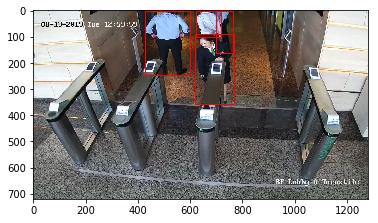

/app/chris/darknet/voc/VOCdevkit/person/labels/person0007.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0007.xml done
1


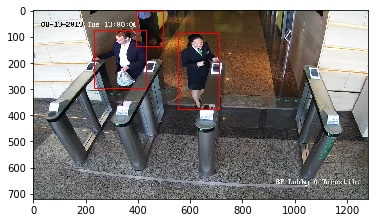

/app/chris/darknet/voc/VOCdevkit/person/labels/person0011.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0011.xml done
2


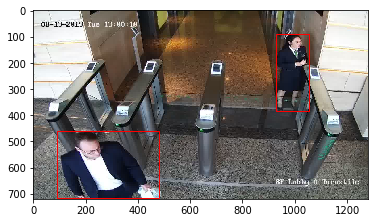

/app/chris/darknet/voc/VOCdevkit/person/labels/person0019.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0019.xml done
3


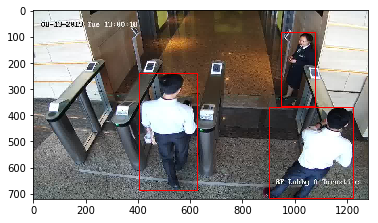

/app/chris/darknet/voc/VOCdevkit/person/labels/person0021.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0021.xml done
4


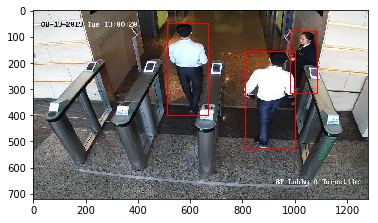

/app/chris/darknet/voc/VOCdevkit/person/labels/person0023.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0023.xml done
5


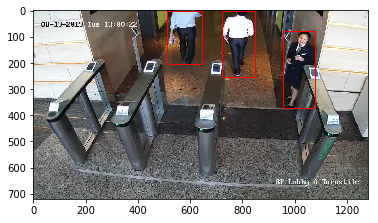

/app/chris/darknet/voc/VOCdevkit/person/labels/person0037.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0037.xml done
6


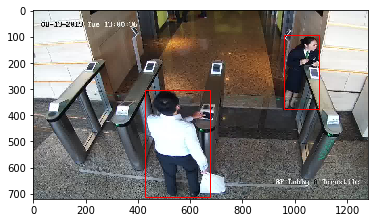

/app/chris/darknet/voc/VOCdevkit/person/labels/person0041.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0041.xml done
7


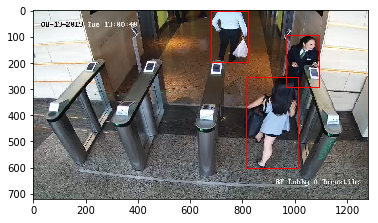

/app/chris/darknet/voc/VOCdevkit/person/labels/person0070.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0070.xml done
8


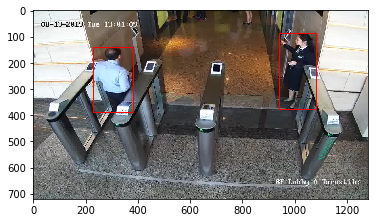

/app/chris/darknet/voc/VOCdevkit/person/labels/person0098.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0098.xml done
9


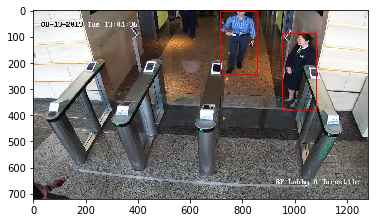

/app/chris/darknet/voc/VOCdevkit/person/labels/person0104.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0104.xml done
10


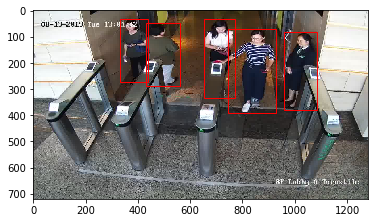

/app/chris/darknet/voc/VOCdevkit/person/labels/person0135.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0135.xml done
11


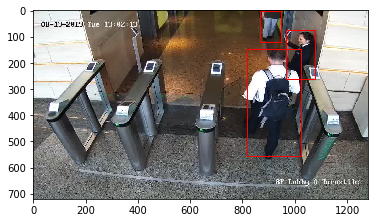

/app/chris/darknet/voc/VOCdevkit/person/labels/person0162.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0162.xml done
12


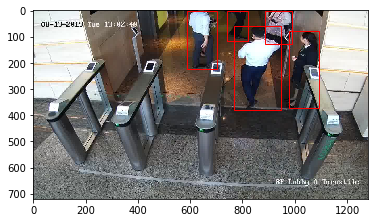

/app/chris/darknet/voc/VOCdevkit/person/labels/person0210.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0210.xml done
13


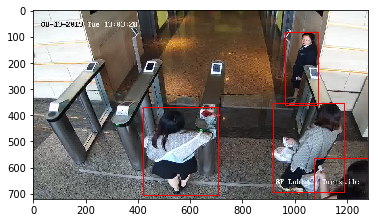

/app/chris/darknet/voc/VOCdevkit/person/labels/person0219.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0219.xml done
14


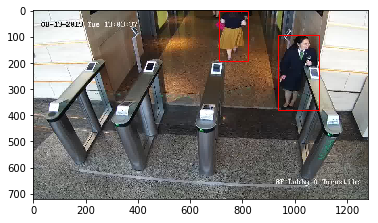

/app/chris/darknet/voc/VOCdevkit/person/labels/person0238.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0238.xml done
15


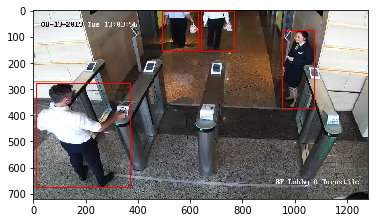

/app/chris/darknet/voc/VOCdevkit/person/labels/person0276.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0276.xml done
16


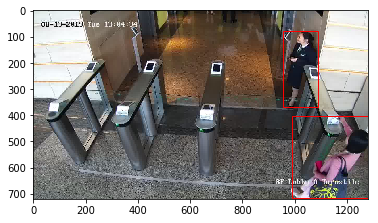

/app/chris/darknet/voc/VOCdevkit/person/labels/person0290.txt
write to /app/chris/darknet/voc/VOCdevkit/person/Annotations/person0290.xml done
17


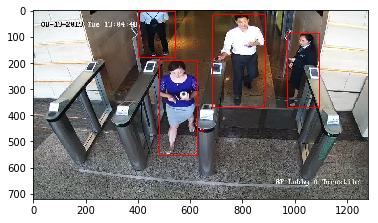

show and generate ended


In [48]:
tfrecord_location = os.path.abspath('./records/')
# name = "Person_20191018_10.record"
# name = "train.record"
# name = "test.record"
name = "Person_20191018_10.record"
filename = os.path.join(tfrecord_location, name)
record_exists = os.path.exists(filename)
record_exists

voc_folder = "/app/chris/darknet/voc/VOCdevkit/person/"
annotations_folder = voc_folder + 'Annotations/'
images_folder = voc_folder + 'JPEGImages/'
dataset = read_tf_records(filename)
generate_voc(dataset, voc_folder, show_num=1000, show_num_steps=1)

In [46]:
def write_train_txt():
    train_txt = voc_folder + 'ImageSets/Main/train.txt'
    print(train_txt)
    if os.path.exists(train_txt):
        os.remove(train_txt)
    print(annotations_folder)
    with open(train_txt, 'a') as f:
        for xml_path in os.listdir(annotations_folder):
            f.write(images_folder + xml_path.rsplit('.', 1)[0] + '.jpg' + '\n')
#             f.write(xml_path.rsplit('.', 1)[0] + '\n')
        f.close()
write_train_txt()

/app/chris/darknet/voc/VOCdevkit/person/ImageSets/Main/train.txt
/app/chris/darknet/voc/VOCdevkit/person/Annotations/
